In [1]:
from os import walk
from functools import reduce
import pandas as pd
import dataframe_image as dfi
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, balanced_accuracy_score, precision_recall_curve, plot_precision_recall_curve

# Load the dataset

In [2]:
data_MCQ160F_eda = pd.read_csv('data_MCQ160F_eda.csv')

In [3]:
data_MCQ160F_eda.shape

(17057, 111)

In [4]:
# Remove rows with missing values in the target variable 'MCQ160F'
data_MCQ160F_nd = data_MCQ160F_eda[data_MCQ160F_eda['MCQ160F'].notna()]

In [5]:
#re-arrannge column
data_MCQ160F_nd = data_MCQ160F_nd[['RIAGENDR', 'BPQ020', 'BPQ080', 'DMQMILIZ', 'DMDCITZN', 'DLQ010', 'DLQ020', 'DLQ040', 'DLQ050', 'DLQ060', 'DLQ080', 'MCQ010', 'MCQ053', 'MCQ092',
                                  'MCQ160A', 'MCQ160N', 'MCQ160B', 'MCQ160C', 'MCQ160D', 'MCQ160E', 'MCQ160G', 'MCQ160M', 'MCQ160K', 'MCQ160L', 'MCQ160O', 'MCQ203',
                                  'MCQ220', 'MCQ300A', 'MCQ300B', 'MCQ300C', 'PFQ049', 'PFQ051', 'DIQ010', 'PAQ620', 'PAQ665', 'PAQ635', 'PAQ605', 'PAQ650',
                                   'PFQ054', 'PFQ057', 'PFQ090', 'DMDBORN4', 'DMDMARTL', 'INDHHIN2', 'INDFMIN2', 'RIDRETH1',
                                    'RIDRETH3', 'DMDEDUC2', 'DMDHHSIZ', 'DMDFMSIZ', 'DMDHHSZE', 'RIDAGEYR',  'OCD150',
                                  'PAD680', 'LBXSCR',
                                   'MCQ160F']]

In [6]:
data_MCQ160F_nd.shape

(17037, 56)

# EDA

## A quick look

In [7]:
# Check correlation matrix
corr_matrix = data_MCQ160F_nd.corr()
corr_matrix["MCQ160F"].sort_values(ascending=False)

MCQ160F     1.000000
PFQ090      0.216152
PFQ051      0.213145
PFQ054      0.211714
PFQ057      0.184546
PFQ049      0.182376
DLQ050      0.180540
MCQ160E     0.173187
DLQ080      0.169885
MCQ160B     0.167463
MCQ160C     0.163779
BPQ020      0.158465
DLQ040      0.150370
DLQ060      0.140874
MCQ160A     0.129282
MCQ092      0.125628
MCQ160D     0.123323
DLQ010      0.122090
DLQ020      0.118233
BPQ080      0.109409
DIQ010      0.102018
DMDHHSIZ    0.100926
DMDFMSIZ    0.094056
MCQ160O     0.092277
INDHHIN2    0.088019
MCQ300A     0.085634
INDFMIN2    0.081186
MCQ160N     0.080729
MCQ160G     0.078940
MCQ220      0.075901
DMDBORN4    0.070536
DMQMILIZ    0.066923
MCQ160K     0.065964
MCQ160M     0.064756
DMDCITZN    0.063060
MCQ053      0.061428
DMDEDUC2    0.052669
MCQ010      0.051701
MCQ300C     0.038048
MCQ160L     0.036806
DMDMARTL    0.036304
MCQ203      0.020034
MCQ300B     0.015358
RIAGENDR    0.004134
RIDRETH3   -0.005294
RIDRETH1   -0.013923
PAQ605     -0.025565
PAQ620     -0

## VIF

In [8]:
# Check Variance Inflation Factor (VIF) to detect multicollinearity
imputer = SimpleImputer(missing_values = np.NaN)
imputed_nd = pd.DataFrame(imputer.fit_transform(data_MCQ160F_nd))
imputed_nd.columns = data_MCQ160F_nd.columns
imputed_nd.index = data_MCQ160F_nd.index

In [9]:
inputs = imputed_nd.drop(['MCQ160F'], axis=1)

In [10]:
def get_vif(inputs):
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(inputs.values, i) for i in range(inputs.shape[1])]
    vif["Feature"] = inputs.columns
    print(vif.round(2).sort_values(by='VIF', ascending=False))
    return vif

In [11]:
vif = get_vif(inputs)

       VIF   Feature
20  252.44   MCQ160G
18  187.26   MCQ160D
45  155.39  RIDRETH1
24  150.45   MCQ160O
16  147.55   MCQ160B
25  144.62    MCQ203
17  137.24   MCQ160C
19  131.79   MCQ160E
46  112.07  RIDRETH3
9   106.09    DLQ060
23   93.05   MCQ160L
43   90.99  INDHHIN2
12   90.77    MCQ053
44   86.35  INDFMIN2
15   86.22   MCQ160N
38   85.67    PFQ054
40   81.83    PFQ090
22   81.83   MCQ160K
10   80.21    DLQ080
39   78.41    PFQ057
6    70.88    DLQ020
48   70.30  DMDHHSIZ
7    65.29    DLQ040
49   65.09  DMDFMSIZ
30   61.30    PFQ049
8    59.97    DLQ050
5    56.22    DLQ010
3    51.92  DMQMILIZ
26   46.70    MCQ220
31   45.64    PFQ051
21   40.65   MCQ160M
13   40.62    MCQ092
27   37.92   MCQ300A
11   32.07    MCQ010
36   27.71    PAQ605
51   27.62  RIDAGEYR
32   26.71    DIQ010
14   23.61   MCQ160A
37   23.30    PAQ650
28   22.92   MCQ300B
4    20.12  DMDCITZN
35   19.10    PAQ635
41   17.93  DMDBORN4
1    17.21    BPQ020
2    16.75    BPQ080
33   16.50    PAQ620
0    14.12  R

In [12]:
# Drop features with high VIF
vif_dropped_columns = ['RIDRETH1', 'MCQ160L', 'MCQ160G', 'MCQ053', 'MCQ203', 'DLQ060', 'MCQ160D', 'MCQ160B', 'MCQ160C', 'INDHHIN2',
                   'MCQ160O', 'MCQ160E', 'PFQ054', 'MCQ160N', 'MCQ160K', 'PFQ090', 'PFQ057', 'DLQ080', 'DLQ020', 'DLQ040',
                   'PFQ049', 'DLQ050', 'DLQ010', 'DMQMILIZ', 'MCQ220', 'DMDFMSIZ', 'MCQ160M', 'MCQ092', 'MCQ010', 'MCQ300A', 'MCQ160A',
                   'DMDHHSIZ', 'DMDCITZN', 'MCQ300B', 'DMDHHSZE', 'PAQ605', 'PAQ650',]

In [13]:
inputs_adjusted_vif = inputs.drop(vif_dropped_columns, axis=1)

In [14]:
vif_adjusted = get_vif(inputs_adjusted_vif)

      VIF   Feature
5   23.78    DIQ010
4   21.79    PFQ051
8   17.56    PAQ635
1   15.76    BPQ020
2   15.46    BPQ080
6   13.75    PAQ620
14  13.58  RIDAGEYR
7   11.77    PAQ665
13  11.75  DMDEDUC2
3   11.54   MCQ300C
0   10.98  RIAGENDR
9    9.93  DMDBORN4
11   6.30  INDFMIN2
12   5.99  RIDRETH3
17   5.26    LBXSCR
15   5.12    OCD150
16   4.98    PAD680
10   3.48  DMDMARTL


In [15]:
# Merge VIF results with feature labels
labels = pd.read_excel('labels.xlsx')
labels2 = labels.drop(['File', 'No NA at all', 'have >90% of data', 'Importance value', 'Importance rank', 'Chosen', 'VIF'], axis=1)

In [16]:
vif_adjusted = pd.merge(vif_adjusted, labels2, on='Feature')

In [17]:
vif_adjusted.sort_values(by="VIF")

,VIF,Feature,Labels
9,3.482073,DMDMARTL,DMDMARTL - Marital status
15,4.982535,PAD680,PAD680 - Minutes sedentary activity
14,5.121009,OCD150,OCD150 - Type of work done last week
16,5.264592,LBXSCR,"LBXSCR - Creatinine, refrigerated serum (mg/dL)"
11,5.986187,RIDRETH3,RIDRETH3 - Race/Hispanic origin w/ NH Asian
10,6.296492,INDFMIN2,INDFMIN2 - Annual family income
8,9.933476,DMDBORN4,DMDBORN4 - Country of birth
0,10.978453,RIAGENDR,RIAGENDR - Gender
12,11.746086,DMDEDUC2,DMDEDUC2 - Education level - Adults 20+
6,11.766395,PAQ665,PAQ665 - Moderate recreational activities


In [18]:
dfi.export(vif_adjusted.sort_values(by="VIF"), 'vif_adjusted.png')

## EDA - with adjusted VIF

In [19]:
data_MCQ160F_nd_final = data_MCQ160F_nd.drop(vif_dropped_columns, axis=1)

In [20]:
data_MCQ160F_nd_final

,RIAGENDR,BPQ020,BPQ080,MCQ300C,PFQ051,DIQ010,PAQ620,PAQ665,PAQ635,DMDBORN4,DMDMARTL,INDFMIN2,RIDRETH3,DMDEDUC2,RIDAGEYR,OCD150,PAD680,LBXSCR,MCQ160F
0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,4.0,4.0,4.0,3.0,69.0,4.0,600.0,1.21,1.0
1,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,7.0,3.0,3.0,54.0,1.0,540.0,0.79,2.0
2,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,10.0,3.0,4.0,72.0,4.0,300.0,1.22,2.0
3,2.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,15.0,3.0,5.0,73.0,4.0,480.0,0.73,2.0
4,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,9.0,1.0,4.0,56.0,1.0,360.0,0.89,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17052,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,7.0,4.0,3.0,64.0,1.0,60.0,NaN,1.0
17053,2.0,2.0,2.0,2.0,2.0,3.0,2.0,1.0,2.0,2.0,1.0,4.0,6.0,3.0,70.0,4.0,120.0,0.70,2.0
17054,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,4.0,12.0,1.0,3.0,42.0,1.0,360.0,0.92,2.0
17055,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,5.0,10.0,4.0,5.0,41.0,3.0,600.0,0.69,2.0


In [21]:
# Rename columns for better readability
data_MCQ160F_nd_final = data_MCQ160F_nd_final.set_axis(['Gender', 'Had_high_blood_pressure', 'Have_high_cholesterol', 'Have_diabetes_close_relative', 'Limited_work_can_do', 'Have_diabetes',
                                                        'Moderate_work_activity', 'Moderate_recreational_activities', 'Walk_or_bicycle',
                                                        'Birth_country', 'Marital_status', 'Annual_family_income', 'Race', 'Education_level', 'Age_at_screening', 'Work_type_last_week',
                                                        'Minutes_sedentary_activity', 'Creatinine_refrigerated_serum', 'Had_stroke'], axis=1)

In [22]:
# Create age groups
age_group = pd.cut(data_MCQ160F_nd_final["Age_at_screening"],
       bins=[data_MCQ160F_nd_final["Age_at_screening"].min()-1, 31, 41, 51, 61, 71, data_MCQ160F_nd_final["Age_at_screening"].max()], 
       labels=["20-30", "31-40", "41-50", "51-60", "61-70", "Greater than 70"])

In [23]:
pd.options.mode.chained_assignment = None
data_MCQ160F_nd_final['Age_group'] = age_group

In [24]:
data_MCQ160F_nd_final

,Gender,Had_high_blood_pressure,Have_high_cholesterol,Have_diabetes_close_relative,Limited_work_can_do,Have_diabetes,Moderate_work_activity,Moderate_recreational_activities,Walk_or_bicycle,Birth_country,Marital_status,Annual_family_income,Race,Education_level,Age_at_screening,Work_type_last_week,Minutes_sedentary_activity,Creatinine_refrigerated_serum,Had_stroke,Age_group
0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,4.0,4.0,4.0,3.0,69.0,4.0,600.0,1.21,1.0,61-70
1,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,7.0,3.0,3.0,54.0,1.0,540.0,0.79,2.0,51-60
2,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,10.0,3.0,4.0,72.0,4.0,300.0,1.22,2.0,Greater than 70
3,2.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,15.0,3.0,5.0,73.0,4.0,480.0,0.73,2.0,Greater than 70
4,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,9.0,1.0,4.0,56.0,1.0,360.0,0.89,2.0,51-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17052,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,7.0,4.0,3.0,64.0,1.0,60.0,NaN,1.0,61-70
17053,2.0,2.0,2.0,2.0,2.0,3.0,2.0,1.0,2.0,2.0,1.0,4.0,6.0,3.0,70.0,4.0,120.0,0.70,2.0,61-70
17054,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,4.0,12.0,1.0,3.0,42.0,1.0,360.0,0.92,2.0,41-50
17055,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,5.0,10.0,4.0,5.0,41.0,3.0,600.0,0.69,2.0,31-40


In [25]:
# Check missing values
na_count_df = pd.DataFrame(data_MCQ160F_nd_final.isnull().sum())

In [26]:
na_count_df = na_count_df.set_axis(['Number of missing values'], axis=1)
na_count_df

,Number of missing values
Gender,0
Had_high_blood_pressure,20
Have_high_cholesterol,115
Have_diabetes_close_relative,307
Limited_work_can_do,21
Have_diabetes,10
Moderate_work_activity,13
Moderate_recreational_activities,4
Walk_or_bicycle,1
Birth_country,8


In [27]:
data_MCQ160F_nd_final_NAsum = pd.DataFrame(data_MCQ160F_nd_final.isnull().sum())
data_MCQ160F_nd_final_NAsum = data_MCQ160F_nd_final_NAsum.set_axis(['NA count'], axis=1)
data_MCQ160F_nd_final_NAsum.sum()

NA count    3580
dtype: int64

In [28]:
# Subset data for EDA
data_MCQ160F_nd_eda = data_MCQ160F_nd_final[:13500]

## Correlations

In [29]:
# Replace numeric values with categorical labels
data_MCQ160F_nd_eda0 = data_MCQ160F_nd_eda.copy()
data_MCQ160F_nd_eda1 = data_MCQ160F_nd_eda.copy()
data_MCQ160F_nd_eda0['Annual_family_income'].replace({1: 2500, 2: 7000, 3: 12500, 4: 17500, 5: 22500, 6: 30000,
                                                                 7: 40000, 8: 50000, 9: 60000, 10: 70000, 12: 35000,
                                                                 13: 15000, 14: 87500, 15: 100000}, inplace=True)
data_MCQ160F_nd_eda0['Race'].replace({1: 'Mexican American', 2: 'Other Hispanic', 3: 'Non-Hispanic White', 4: 'Non-Hispanic Black',
                                                  6: 'Non-Hispanic Asian', 7: 'Other Race'}, inplace=True)
data_MCQ160F_nd_eda0['Education_level'].replace({1: 'Less than 9th grade', 2: '9-11th grade', 3: 'High school graduate', 4: 'Some college or AA degree',
                                                            5: 'College graduate or above'}, inplace=True)
data_MCQ160F_nd_eda0['Marital_status'].replace({1: 'Married', 2: 'Widowed', 3: 'Divorced', 4: 'Separated', 5: 'Never married', 6: 'Living with partner',}, inplace=True)

In [30]:
data_MCQ160F_nd_eda.to_csv('data_MCQ160F_nd_eda.csv')

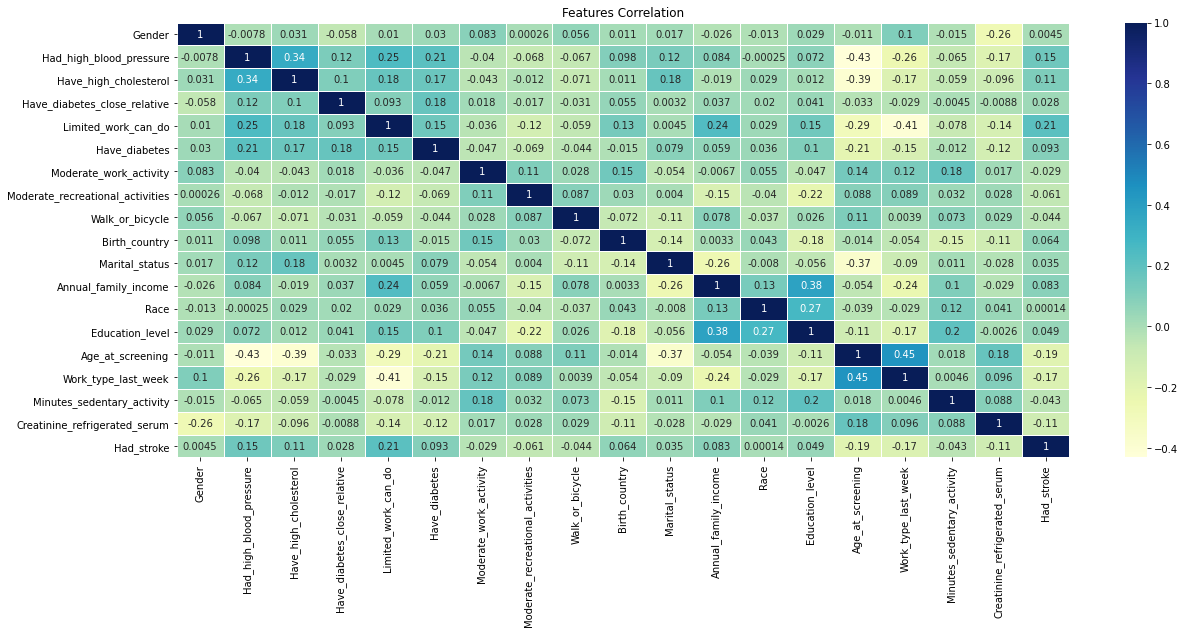

In [31]:
# Visualize correlation matrix
fig = plt.figure(figsize = (20,8))
sns.heatmap(data_MCQ160F_nd_eda1.corr(), annot = True, linewidths=.5, cmap="YlGnBu")
plt.title('Features Correlation')
plt.show()

## Distribution

In [32]:
# Distribution analysis
target_column = 'Had_stroke'
data_MCQ160F_nd_eda[target_column].replace({1: 'Yes', 2: 'No'}, inplace=True)
data_MCQ160F_nd_final[target_column].replace({1: 'Yes', 2: 'No'}, inplace=True)
data_MCQ160F_nd_final[target_column].value_counts()

No     16353
Yes      684
Name: Had_stroke, dtype: int64

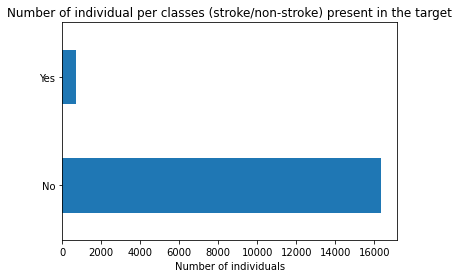

In [33]:
data_MCQ160F_nd_final[target_column].value_counts().plot.barh()
plt.xlabel("Number of individuals")
plt.title("Number of individual per classes (stroke/non-stroke) present in the target")
plt.show()

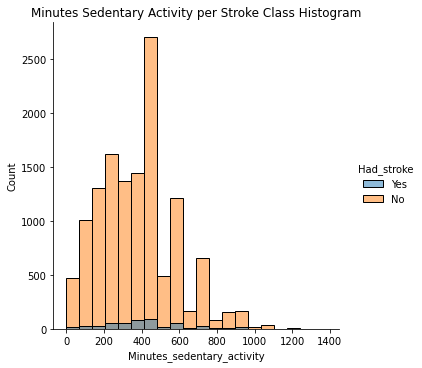

In [34]:
sns.displot(data=data_MCQ160F_nd_eda, x="Minutes_sedentary_activity", hue = 'Had_stroke', bins = 20)
plt.title('Minutes Sedentary Activity per Stroke Class Histogram')
plt.show()

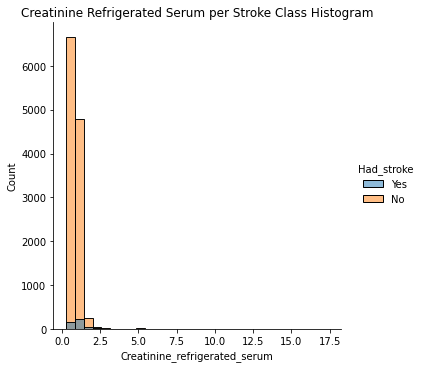

In [35]:
sns.displot(data=data_MCQ160F_nd_eda, x="Creatinine_refrigerated_serum", hue = 'Had_stroke', bins = 30)
plt.title('Creatinine Refrigerated Serum per Stroke Class Histogram')
plt.show()

In [36]:
col_names = data_MCQ160F_nd_eda.columns.values
col_names

array(['Gender', 'Had_high_blood_pressure', 'Have_high_cholesterol',
       'Have_diabetes_close_relative', 'Limited_work_can_do',
       'Have_diabetes', 'Moderate_work_activity',
       'Moderate_recreational_activities', 'Walk_or_bicycle',
       'Birth_country', 'Marital_status', 'Annual_family_income', 'Race',
       'Education_level', 'Age_at_screening', 'Work_type_last_week',
       'Minutes_sedentary_activity', 'Creatinine_refrigerated_serum',
       'Had_stroke', 'Age_group'], dtype=object)

In [37]:
# Function to change numeric values to categorical variables
def change_numeric_to_categorical_variables(data, col_names, start_column, end_column):
    data['Gender'].replace({1: 'Male', 2: 'Female'}, inplace=True)
    data['Have_diabetes'].replace({1: 'Yes', 2: 'No', 3: 'Borderline'}, inplace=True)
    data['Birth_country'].replace({1: 'USA', 2: 'Others'}, inplace=True)
    data['Marital_status'].replace({1: 'Married', 2: 'Widowed', 3: 'Divorced', 4: 'Separated', 5: 'Never married', 6: 'Living with partner',}, inplace=True)
    data['Annual_family_income'].replace({1: '0-4.99k', 2: '5-9k', 3: '10-14.99k', 4: '15-19.99k', 5: '20-24.99k', 6: '25-34.99k',
                                                                     7: '35-44.99k', 8: '45-54.99k', 9: '55-64.99k', 10: '65-74.99k', 12: '20k and over',
                                                                     13: 'under 20k', 14: '75-99.99k', 15: '100k and over'}, inplace=True)
    data['Race'].replace({1: 'Mexican American', 2: 'Other Hispanic', 3: 'Non-Hispanic White', 4: 'Non-Hispanic Black',
                                                      6: 'Non-Hispanic Asian', 7: 'Other Race'}, inplace=True)
    data['Education_level'].replace({1: 'Less than 9th grade', 2: '9-11th grade', 3: 'High school graduate', 4: 'Some college or AA degree',
                                                                5: 'College graduate or above'}, inplace=True)
    data['Work_type_last_week'].replace({1: 'Working', 2: 'Working (not at work)', 3: 'Looking for work', 4: 'Not working'}, inplace=True)
    for col in col_names[start_column:end_column]:
            data[col].replace({1: 'Yes', 2: 'No'}, inplace=True)
    return data

In [38]:
data_MCQ160F_nd_eda = change_numeric_to_categorical_variables(data_MCQ160F_nd_eda, col_names, 1, 9)

In [39]:
# Export final data
data_MCQ160F_nd_final.to_csv('data_MCQ160F_nd_final.csv')

c:\program files\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\program files\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\program files\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\program files\python39\li

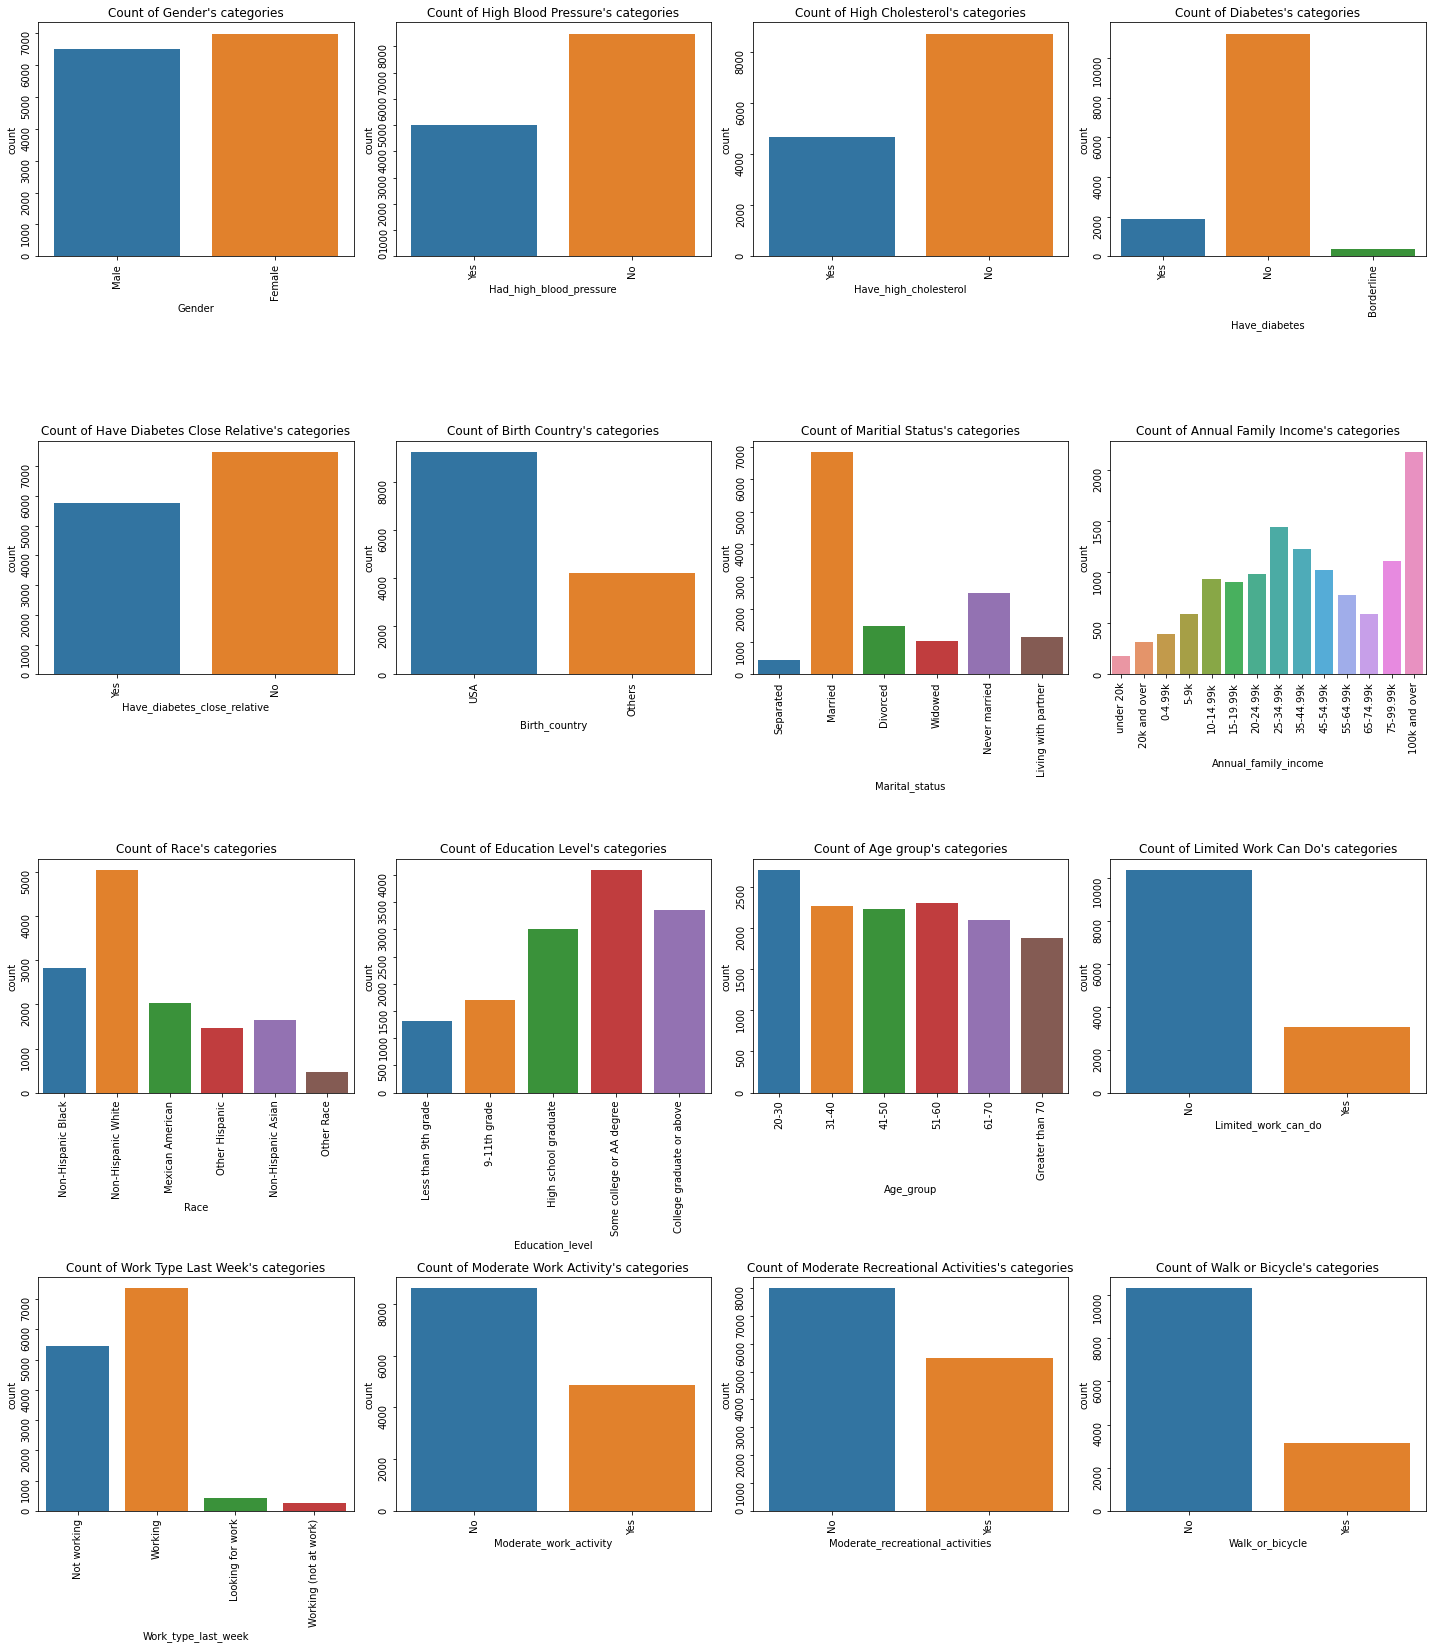

In [40]:
# Visualize categorical variables
fig, axes = plt.subplots(4, 4, figsize=(20, 23))
sns.countplot(data_MCQ160F_nd_eda['Gender'], ax=axes[0, 0])
sns.countplot(data_MCQ160F_nd_eda['Had_high_blood_pressure'], ax=axes[0, 1])
sns.countplot(data_MCQ160F_nd_eda['Have_high_cholesterol'], ax=axes[0, 2])
sns.countplot(data_MCQ160F_nd_eda['Have_diabetes'], ax=axes[0, 3])
sns.countplot(data_MCQ160F_nd_eda['Have_diabetes_close_relative'], ax=axes[1, 0])
sns.countplot(data_MCQ160F_nd_eda['Birth_country'], ax=axes[1, 1])
sns.countplot(data_MCQ160F_nd_eda['Marital_status'], ax=axes[1, 2])
sns.countplot(data_MCQ160F_nd_eda['Annual_family_income'], order =  ['under 20k', '20k and over','0-4.99k', '5-9k', '10-14.99k', '15-19.99k', '20-24.99k', '25-34.99k',
                                                                 '35-44.99k', '45-54.99k', '55-64.99k', '65-74.99k',
                                                                 '75-99.99k', '100k and over'], ax=axes[1, 3])
sns.countplot(data_MCQ160F_nd_eda['Race'], ax=axes[2, 0])
sns.countplot(data_MCQ160F_nd_eda['Education_level'], order = ['Less than 9th grade', '9-11th grade', 'High school graduate', 'Some college or AA degree',
                                                            'College graduate or above'], ax=axes[2, 1])
sns.countplot(data_MCQ160F_nd_eda['Age_group'], ax=axes[2, 2])
sns.countplot(data_MCQ160F_nd_eda['Limited_work_can_do'], ax=axes[2, 3])
sns.countplot(data_MCQ160F_nd_eda['Work_type_last_week'], ax=axes[3, 0])
sns.countplot(data_MCQ160F_nd_eda['Moderate_work_activity'], ax=axes[3, 1])
sns.countplot(data_MCQ160F_nd_eda['Moderate_recreational_activities'], ax=axes[3, 2])
sns.countplot(data_MCQ160F_nd_eda['Walk_or_bicycle'], ax=axes[3, 3])
for ax in fig.axes:
    ax.tick_params(labelrotation=90)
axes[0, 0].title.set_text("Count of Gender's categories")
axes[0, 1].title.set_text("Count of High Blood Pressure's categories")
axes[0, 2].title.set_text("Count of High Cholesterol's categories")
axes[0, 3].title.set_text("Count of Diabetes's categories")
axes[1, 0].title.set_text("Count of Have Diabetes Close Relative's categories")
axes[1, 1].title.set_text("Count of Birth Country's categories")
axes[1, 2].title.set_text("Count of Maritial Status's categories")
axes[1, 3].title.set_text("Count of Annual Family Income's categories")
axes[2, 0].title.set_text("Count of Race's categories")
axes[2, 1].title.set_text("Count of Education Level's categories")
axes[2, 2].title.set_text("Count of Age group's categories")
axes[2, 3].title.set_text("Count of Limited Work Can Do's categories")
axes[3, 0].title.set_text("Count of Work Type Last Week's categories")
axes[3, 1].title.set_text("Count of Moderate Work Activity's categories")
axes[3, 2].title.set_text("Count of Moderate Recreational Activities's categories")
axes[3, 3].title.set_text("Count of Walk or Bicycle's categories")
fig.tight_layout()
plt.show()

In [41]:
def plot_stacked_barchart(x, title):
    ax= pd.crosstab(data_MCQ160F_nd_eda[x], data_MCQ160F_nd_eda['Had_stroke']).apply(lambda r: r/r.sum()*100, axis=1)
    ax_1 = ax.plot.bar(figsize=(6,5),stacked=True, rot=0)

    plt.legend(loc='upper center', bbox_to_anchor=(0.1, 1.0))

    plt.xlabel(x)
    plt.ylabel('Percent distribution of people who had stroke')

    for rec in ax_1.patches:
        height = rec.get_height()
        ax_1.text(rec.get_x() + rec.get_width() / 2, 
                  rec.get_y() + height / 2,
                  "{:.0f}%".format(height),
                  ha='center', 
                  va='bottom')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title(title)
    plt.show()

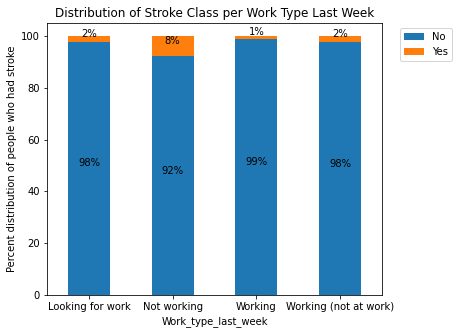

In [42]:
plot_stacked_barchart('Work_type_last_week', 'Distribution of Stroke Class per Work Type Last Week')

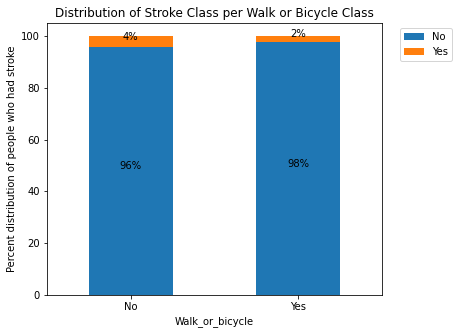

In [43]:
plot_stacked_barchart('Walk_or_bicycle', 'Distribution of Stroke Class per Walk or Bicycle Class')

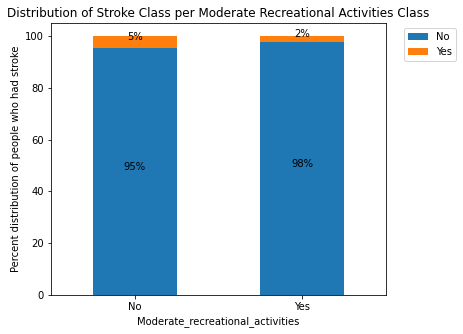

In [44]:
plot_stacked_barchart('Moderate_recreational_activities', 'Distribution of Stroke Class per Moderate Recreational Activities Class')

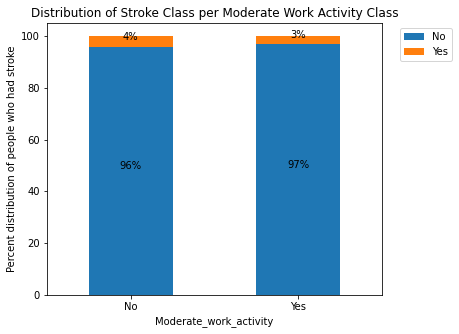

In [45]:
plot_stacked_barchart('Moderate_work_activity', 'Distribution of Stroke Class per Moderate Work Activity Class')

## Features interaction

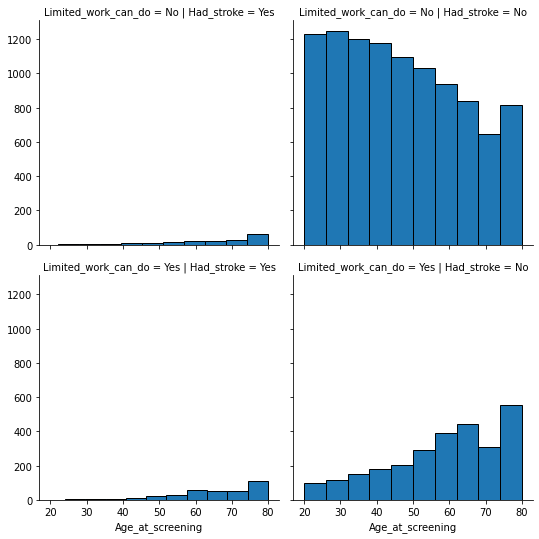

In [46]:
g = sns.FacetGrid(data_MCQ160F_nd_eda, col = 'Had_stroke', row = 'Limited_work_can_do', height = 3.8)
g = g.map(plt.hist, 'Age_at_screening', edgecolor = 'black')

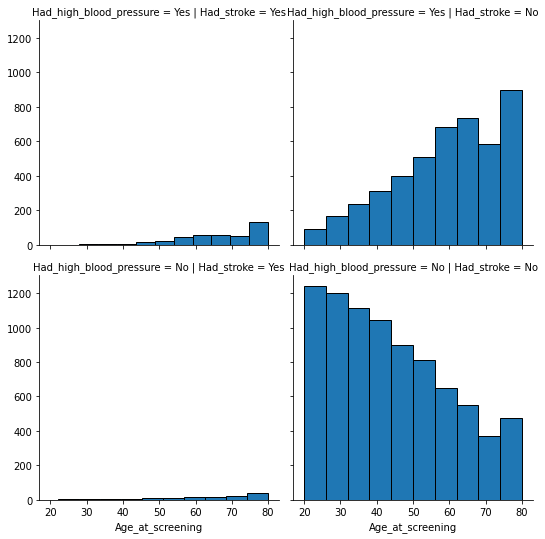

In [47]:
g = sns.FacetGrid(data_MCQ160F_nd_eda, col = 'Had_stroke', row = 'Had_high_blood_pressure', height = 3.8)
g = g.map(plt.hist, 'Age_at_screening', edgecolor = 'black')

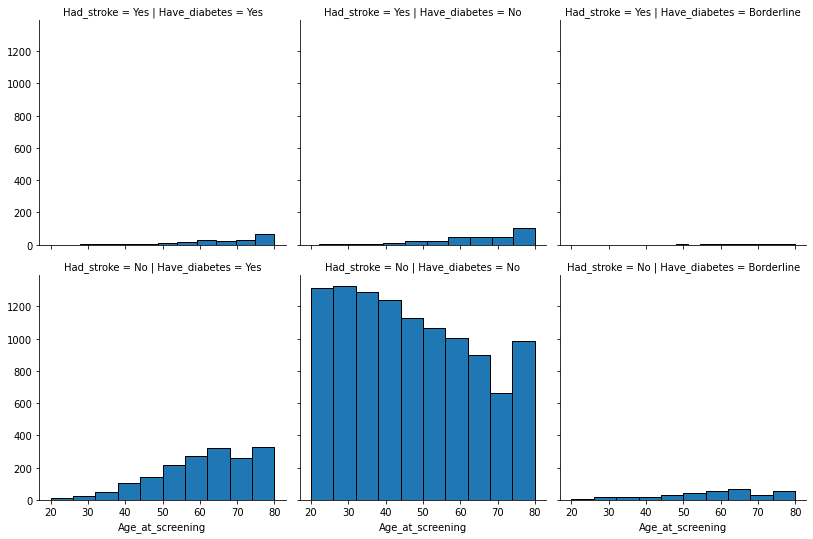

In [48]:
g = sns.FacetGrid(data_MCQ160F_nd_eda, row = 'Had_stroke', col = 'Have_diabetes', height = 3.8)
g = g.map(plt.hist, 'Age_at_screening', edgecolor = 'black')

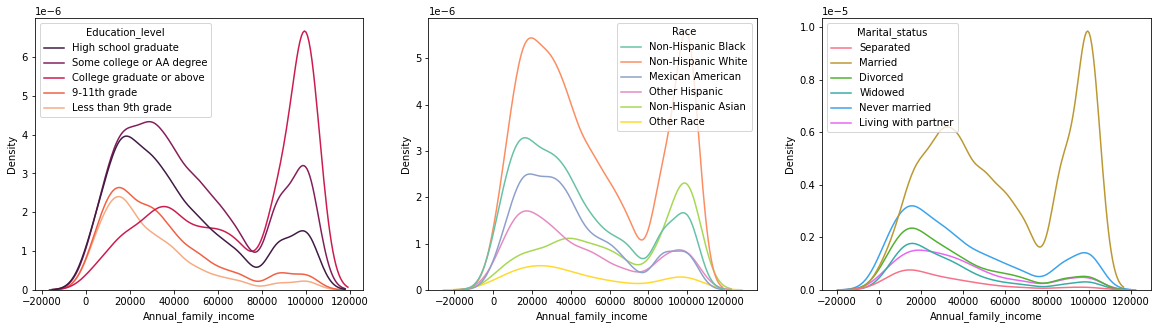

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.kdeplot(data=data_MCQ160F_nd_eda0, x="Annual_family_income", hue = 'Education_level', palette="rocket", ax=axes[0])
sns.kdeplot(data=data_MCQ160F_nd_eda0, x="Annual_family_income", hue = 'Race', palette="Set2", ax=axes[1])
sns.kdeplot(data=data_MCQ160F_nd_eda0, x="Annual_family_income", hue = 'Marital_status', palette="husl", ax=axes[2])
plt.show()

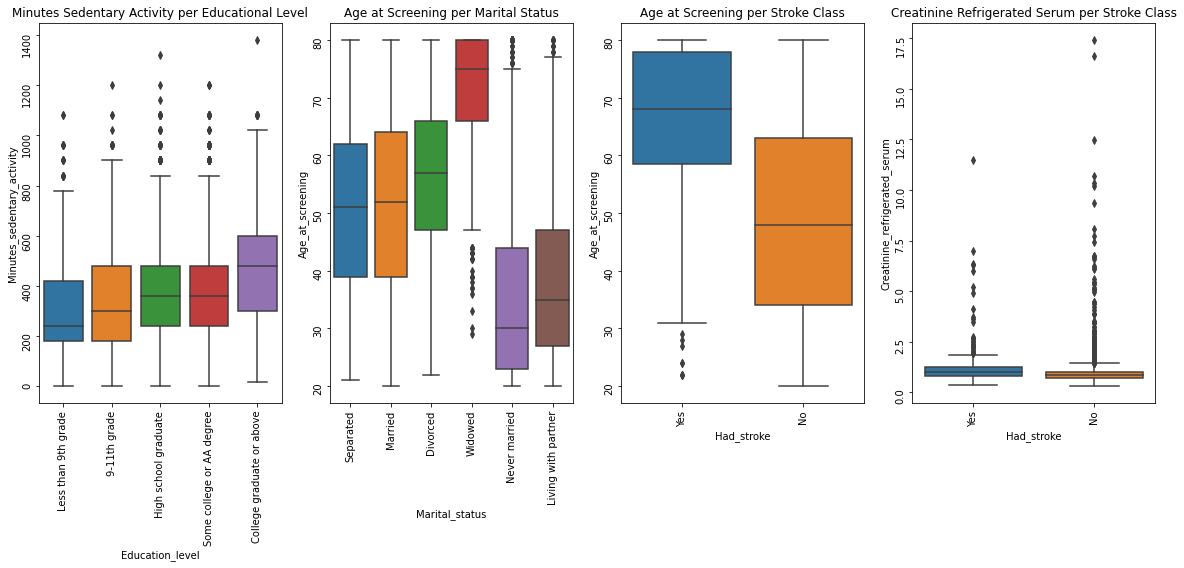

In [50]:
fig, axes = plt.subplots(1, 4, figsize=(20, 7))
sns.boxplot(y='Minutes_sedentary_activity', x='Education_level', data=data_MCQ160F_nd_eda, order = ['Less than 9th grade', '9-11th grade', 'High school graduate', 'Some college or AA degree',
                                                            'College graduate or above'], ax=axes[0])
sns.boxplot(y='Age_at_screening', x='Marital_status', data=data_MCQ160F_nd_eda, ax=axes[1])
sns.boxplot(y='Age_at_screening', x='Had_stroke', data=data_MCQ160F_nd_eda, ax=axes[2])
sns.boxplot(y='Creatinine_refrigerated_serum', x='Had_stroke', data=data_MCQ160F_nd_eda, ax=axes[3])
for ax in fig.axes:
    ax.tick_params(labelrotation=90)
axes[0].title.set_text("Minutes Sedentary Activity per Educational Level")
axes[1].title.set_text("Age at Screening per Marital Status")
axes[2].title.set_text("Age at Screening per Stroke Class")
axes[3].title.set_text("Creatinine Refrigerated Serum per Stroke Class")

# Classification

## With all chosen features

In [51]:
# Drop 'Age_at_screening' column from the dataset
data_MCQ160F_lr = data_MCQ160F_nd_final.drop(['Age_at_screening'], axis=1)

In [52]:
# Select specific columns for the analysis
data_MCQ160F_lr = data_MCQ160F_lr[['Minutes_sedentary_activity', 'Creatinine_refrigerated_serum', 'Gender', 'Had_high_blood_pressure', 'Have_high_cholesterol', 'Have_diabetes_close_relative', 'Limited_work_can_do', 'Have_diabetes',
                                    'Moderate_work_activity', 'Moderate_recreational_activities', 'Walk_or_bicycle',
                                    'Birth_country', 'Marital_status', 'Annual_family_income', 'Race', 'Education_level', 'Age_group', 'Work_type_last_week',
                                    'Had_stroke']]

In [53]:
# Get the column names of the dataset
col_names_lr = data_MCQ160F_lr.columns.values
col_names_lr

array(['Minutes_sedentary_activity', 'Creatinine_refrigerated_serum',
       'Gender', 'Had_high_blood_pressure', 'Have_high_cholesterol',
       'Have_diabetes_close_relative', 'Limited_work_can_do',
       'Have_diabetes', 'Moderate_work_activity',
       'Moderate_recreational_activities', 'Walk_or_bicycle',
       'Birth_country', 'Marital_status', 'Annual_family_income', 'Race',
       'Education_level', 'Age_group', 'Work_type_last_week',
       'Had_stroke'], dtype=object)

In [54]:
# Convert numeric variables to categorical variables
data_MCQ160F_lr = change_numeric_to_categorical_variables(data_MCQ160F_lr, col_names_lr, 2, 11)
data_MCQ160F_lr

,Minutes_sedentary_activity,Creatinine_refrigerated_serum,Gender,Had_high_blood_pressure,Have_high_cholesterol,Have_diabetes_close_relative,Limited_work_can_do,Have_diabetes,Moderate_work_activity,Moderate_recreational_activities,Walk_or_bicycle,Birth_country,Marital_status,Annual_family_income,Race,Education_level,Age_group,Work_type_last_week,Had_stroke
0,600.0,1.21,Male,Yes,Yes,Yes,No,Yes,No,No,No,USA,Separated,15-19.99k,Non-Hispanic Black,High school graduate,61-70,Not working,Yes
1,540.0,0.79,Male,Yes,Yes,Yes,No,Yes,Yes,No,No,USA,Married,35-44.99k,Non-Hispanic White,High school graduate,51-60,Working,No
2,300.0,1.22,Male,Yes,Yes,No,No,Yes,Yes,Yes,No,USA,Married,65-74.99k,Non-Hispanic White,Some college or AA degree,Greater than 70,Not working,No
3,480.0,0.73,Female,Yes,No,No,Yes,No,Yes,No,No,USA,Married,100k and over,Non-Hispanic White,College graduate or above,Greater than 70,Not working,No
4,360.0,0.89,Male,Yes,Yes,No,Yes,No,No,No,No,USA,Divorced,55-64.99k,Mexican American,Some college or AA degree,51-60,Working,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17052,60.0,NaN,Male,Yes,Yes,Yes,Yes,No,No,No,No,USA,Married,35-44.99k,Non-Hispanic Black,High school graduate,61-70,Working,Yes
17053,120.0,0.70,Female,No,No,No,No,Borderline,No,Yes,No,Others,Married,15-19.99k,Non-Hispanic Asian,High school graduate,61-70,Not working,No
17054,360.0,0.92,Male,No,Yes,No,No,No,Yes,No,No,Others,Separated,20k and over,Mexican American,High school graduate,41-50,Working,No
17055,600.0,0.69,Female,No,No,Yes,Yes,No,No,Yes,No,USA,Never married,65-74.99k,Non-Hispanic Black,College graduate or above,31-40,Looking for work,No


In [55]:
# Replace values in 'Annual_family_income' and 'Had_stroke' columns
data_MCQ160F_lr["Annual_family_income"].replace({"under 20k": "15-19.99k", "20k and over": "35-44.99k"}, inplace=True)
data_MCQ160F_lr["Had_stroke"].replace({'Yes': 1, 'No': 0}, inplace=True)

In [56]:
# Create dummy variables for categorical features
data_MCQ160F_have_dummies = pd.get_dummies(data_MCQ160F_lr, drop_first=True, dummy_na=False)
data_MCQ160F_have_dummies

,Minutes_sedentary_activity,Creatinine_refrigerated_serum,Had_stroke,Gender_Male,Had_high_blood_pressure_Yes,Have_high_cholesterol_Yes,Have_diabetes_close_relative_Yes,Limited_work_can_do_Yes,Have_diabetes_No,Have_diabetes_Yes,...,Education_level_Less than 9th grade,Education_level_Some college or AA degree,Age_group_31-40,Age_group_41-50,Age_group_51-60,Age_group_61-70,Age_group_Greater than 70,Work_type_last_week_Not working,Work_type_last_week_Working,Work_type_last_week_Working (not at work)
0,600.0,1.21,1,1,1,1,1,0,0,1,...,0,0,0,0,0,1,0,1,0,0
1,540.0,0.79,0,1,1,1,1,0,0,1,...,0,0,0,0,1,0,0,0,1,0
2,300.0,1.22,0,1,1,1,0,0,0,1,...,0,1,0,0,0,0,1,1,0,0
3,480.0,0.73,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,1,1,0,0
4,360.0,0.89,0,1,1,1,0,1,1,0,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17052,60.0,NaN,1,1,1,1,1,1,1,0,...,0,0,0,0,0,1,0,0,1,0
17053,120.0,0.70,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
17054,360.0,0.92,0,1,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
17055,600.0,0.69,0,0,0,0,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0


In [57]:
# Get the column names of the dataset with dummy variables
col_names_lr2 = list(data_MCQ160F_have_dummies.columns.values)

In [58]:
# Remove specific columns from the list of column names
col_names_lr2.remove('Minutes_sedentary_activity')
col_names_lr2.remove('Creatinine_refrigerated_serum')
col_names_lr2.remove('Had_stroke')

In [59]:
# Rearrange the columns by appending specific columns at the end
rearranged_columns = []
for col in col_names_lr2:
    rearranged_columns.append(col)

rearranged_columns.append('Minutes_sedentary_activity')
rearranged_columns.append('Creatinine_refrigerated_serum')
rearranged_columns.append('Had_stroke')
rearranged_columns

['Gender_Male',
 'Had_high_blood_pressure_Yes',
 'Have_high_cholesterol_Yes',
 'Have_diabetes_close_relative_Yes',
 'Limited_work_can_do_Yes',
 'Have_diabetes_No',
 'Have_diabetes_Yes',
 'Moderate_work_activity_Yes',
 'Moderate_recreational_activities_Yes',
 'Walk_or_bicycle_Yes',
 'Birth_country_USA',
 'Marital_status_Living with partner',
 'Marital_status_Married',
 'Marital_status_Never married',
 'Marital_status_Separated',
 'Marital_status_Widowed',
 'Annual_family_income_10-14.99k',
 'Annual_family_income_100k and over',
 'Annual_family_income_15-19.99k',
 'Annual_family_income_20-24.99k',
 'Annual_family_income_25-34.99k',
 'Annual_family_income_35-44.99k',
 'Annual_family_income_45-54.99k',
 'Annual_family_income_5-9k',
 'Annual_family_income_55-64.99k',
 'Annual_family_income_65-74.99k',
 'Annual_family_income_75-99.99k',
 'Race_Non-Hispanic Asian',
 'Race_Non-Hispanic Black',
 'Race_Non-Hispanic White',
 'Race_Other Hispanic',
 'Race_Other Race',
 'Education_level_College gra

In [60]:
# Rearrange the columns in the dataset
data_MCQ160F_lr_preprocessed = data_MCQ160F_have_dummies[rearranged_columns]

In [61]:
# Get the shape of the preprocessed dataset
data_MCQ160F_lr_preprocessed.shape

(17037, 47)

In [62]:
# Remove 'Had_stroke' column from the list of rearranged columns
rearranged_columns_2 = list(data_MCQ160F_lr_preprocessed.columns.values)
rearranged_columns_2.remove('Had_stroke')

In [63]:
# Check for missing values in the preprocessed dataset
data_MCQ160F_lr_preprocessed.isnull().sum()

Gender_Male                                     0
Had_high_blood_pressure_Yes                     0
Have_high_cholesterol_Yes                       0
Have_diabetes_close_relative_Yes                0
Limited_work_can_do_Yes                         0
Have_diabetes_No                                0
Have_diabetes_Yes                               0
Moderate_work_activity_Yes                      0
Moderate_recreational_activities_Yes            0
Walk_or_bicycle_Yes                             0
Birth_country_USA                               0
Marital_status_Living with partner              0
Marital_status_Married                          0
Marital_status_Never married                    0
Marital_status_Separated                        0
Marital_status_Widowed                          0
Annual_family_income_10-14.99k                  0
Annual_family_income_100k and over              0
Annual_family_income_15-19.99k                  0
Annual_family_income_20-24.99k                  0


In [64]:
# Define a function for data preprocessing
def data_preprocessing(data, sc_column):
    # Splitting the dataset
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    # Encoding the dependent variable
#     le = LabelEncoder()
#     y = le.fit_transform(y)
    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
    # Handling missing values
    mice_imputer = IterativeImputer()
    X_train = mice_imputer.fit_transform(X_train)
    X_test = mice_imputer.transform(X_test)
    # Feature Scaling
    sc = StandardScaler()
    X_train[:, sc_column:] = sc.fit_transform(X_train[:, sc_column:])
    X_test[:, sc_column:] = sc.transform(X_test[:, sc_column:])
    return X_train, X_test, y_train, y_test

In [65]:
# Preprocess the data
X_train, X_test, y_train, y_test = data_preprocessing(data_MCQ160F_lr_preprocessed, 44)

In [66]:
X_train

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.66458562, -0.75713456],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
        -0.36722384, -0.73448776],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
        -0.36722384, -0.53066652],
       ...,
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
        -0.06986206, -0.34949208],
       [ 0.        ,  1.        ,  1.        , ...,  0.        ,
         1.11958506, -0.10037723],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
        -0.9619474 ,  0.5563801 ]])

In [67]:
y_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [68]:
# Define functions for running different classifiers and evaluating their performance
def run_svc_classifier(X_train, X_test, y_train, y_test, kernel):
    classifier = SVC(kernel = kernel, random_state = 0)
    classifier.fit(X_train, y_train)
    return get_performance_scores(classifier, X_train, X_test, y_train, y_test)

def run_random_forest_classifier(X_train, X_test, y_train, y_test, n_estimators, criterion):
    classifier = RandomForestClassifier(n_estimators = n_estimators, criterion = criterion, random_state = 0)
    classifier.fit(X_train, y_train)
    return get_performance_scores(classifier, X_train, X_test, y_train, y_test)

def run_logistic_regression_classifier(X_train, X_test, y_train, y_test):
    classifier = LogisticRegression(random_state = 0)
    classifier.fit(X_train, y_train)
    return get_performance_scores(classifier, X_train, X_test, y_train, y_test)

def get_performance_scores(classifier, X_train, X_test, y_train, y_test):
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    cv = RepeatedStratifiedKFold(n_splits=5,  n_repeats=3, random_state=0)
    accuracy = cross_val_score(classifier, X_train, y_train, scoring = 'accuracy', cv=cv, n_jobs=-1)
    precision = cross_val_score(classifier, X_train, y_train, scoring = 'precision', cv=cv, n_jobs=-1)
    recall = cross_val_score(classifier, X_train, y_train, scoring = 'recall', cv=cv, n_jobs=-1)
    f1 = cross_val_score(classifier, X_train, y_train, scoring = 'f1', cv=cv, n_jobs=-1)
    auc = cross_val_score(classifier, X_train, y_train, scoring = 'roc_auc', cv=cv, n_jobs=-1)
    print("Accuracy score k-fold: {:.2f}".format(np.mean(accuracy)))
    print("Precision score k-fold: {:.2f}".format(np.mean(precision)))
    print("Recall score k-fold: {:.2f}".format(np.mean(recall)))
    print("F1 score k-fold: {:.2f}".format(np.mean(f1)))
    print("AUC k-fold: {:.2f}".format(np.mean(auc)))
    return accuracy, precision, recall, f1, auc, classifier

In [69]:
# Run logistic regression classifier and get performance scores
lr_accuracy, lr_precision, lr_recall, lr_f1, lr_auc, lr_clf = run_logistic_regression_classifier(X_train, X_test, y_train, y_test)

[[3270    1]
 [ 137    0]]
Accuracy score k-fold: 0.96
Precision score k-fold: 0.16
Recall score k-fold: 0.00
F1 score k-fold: 0.00
AUC k-fold: 0.85


In [70]:
# Convert the training features to a DataFrame
X_train_df = pd.DataFrame(data = X_train, columns = rearranged_columns_2)

In [71]:
# Fit a logistic regression model using statsmodels
x = sm.add_constant(X_train_df)
reg_log = sm.Logit(y_train, X_train_df)
results_log = reg_log.fit(method='bfgs')

# Get the regression summary
results_log.summary()

c:\program files\python39\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
c:\program files\python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.136859
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                13629
Model:                          Logit   Df Residuals:                    13583
Method:                           MLE   Df Model:                           45
Date:                Wed, 27 Oct 2021   Pseudo R-squ.:                  0.1872
Time:                        16:14:34   Log-Likelihood:                -1865.3
converged:                      False   LL-Null:                       -2294.8
Covariance Type:            nonrobust   LLR p-value:                5.294e-151
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Gender_Male                                  -0.1191      0.097     -1.222      0.222      -0.310       0.072
Had_high_blood_pressure_Yes                   0.5239      0.113      4.626      0.000       0.302       0.746
Have_high_cholesterol_Yes                     0.3288      0.100      3.283      0.001       0.133       0.525
Have_diabetes_close_relative_Yes             -0.1286      0.098     -1.314      0.189      -0.320       0.063
Limited_work_can_do_Yes                       0.9649      0.106      9.115      0.000       0.757       1.172
Have_diabetes_No                             -1.4847      0.157     -9.480      0.000      -1.792      -1.178
Have_diabetes_Yes                            -0.9470      0.171     -5.538      0.000      -1.282      -0.612
Moderate_work_activity_Yes                   -0.0157      0.105     -0.150      0.881      -0.221       0.190
Moderate_recreational_activities_Yes         -0.5061      0.111     -4.552      0.000      -0.724      -0.288
Walk_or_bicycle_Yes                          -0.5220      0.140     -3.732      0.000      -0.796      -0.248
Birth_country_USA                            -0.0688      0.154     -0.446      0.656      -0.371       0.234
Marital_status_Living with partner           -0.5587      0.229     -2.435      0.015      -1.008      -0.109
Marital_status_Married                       -0.3196      0.131     -2.445      0.014      -0.576      -0.063
Marital_status_Never married                 -0.8260      0.187     -4.410      0.000      -1.193      -0.459
Marital_status_Separated                     -0.3092      0.248     -1.246      0.213      -0.796       0.177
Marital_status_Widowed                       -0.2025      0.158     -1.282      0.200      -0.512       0.107
Annual_family_income_10-14.99k                0.2631      0.178      1.476      0.140      -0.086       0.613
Annual_family_income_100k and over           -0.4041      0.231     -1.749      0.080      -0.857       0.049
Annual_family_income_15-19.99k               -0.1995      0.195     -1.024      0.306      -0.581       0.182
Annual_family_income_20-24.99k                0.0120      0.194      0.062      0.951      -0.368       0.392
Annual_family_income_25-34.99k               -0.3343      0.194     -1.723      0.085      -0.715       0.046
Annual_family_income_35-44.99k               -0.2419      0.194     -1.250      0.211      -0.621       0.137
Annual_family_income_45-54.99k               -0.0246      0.219     -0.112      0.911      -0.455       0.405
Annual_family_income_5-9k                    -0.3799      0.236     -1.608      0.108      -0.843       0.083
Annual_family_income_55-64.99k               -0.2667      0.261     -1.020      0.308      -0.779       0.246
Annual_family_income_65-74.99k               -0.0979      0.274     -0.357      0.721      -0.635       0.440
Annual_family_income_75-99.99k               -0.295

In [72]:
# Extract and format the regression results
results = results_log.params.to_frame().reset_index()
results_pvalues = results_log.pvalues.to_frame().reset_index()
results_ci_0025 = results_log.conf_int()[0].to_frame().reset_index()
results_ci_0975 = results_log.conf_int()[1].to_frame().reset_index()

results = pd.merge(results, results_ci_0025, on='index')
results = pd.merge(results, results_ci_0975, on='index')

numerics = results.select_dtypes(include="number").columns
results[numerics] = results[numerics].apply(np.exp)
results = pd.merge(results, results_pvalues, on='index')
results = results.set_axis(['Feature', 'Odds Ratio', '2.5% CI', '97.5% CI', 'p-values'], axis=1)
results.round(3)

,Feature,Odds Ratio,2.5% CI,97.5% CI,p-values
0,Gender_Male,0.888,0.733,1.075,0.222
1,Had_high_blood_pressure_Yes,1.689,1.353,2.108,0.000
2,Have_high_cholesterol_Yes,1.389,1.142,1.691,0.001
3,Have_diabetes_close_relative_Yes,0.879,0.726,1.065,0.189
4,Limited_work_can_do_Yes,2.624,2.133,3.230,0.000
5,Have_diabetes_No,0.227,0.167,0.308,0.000
6,Have_diabetes_Yes,0.388,0.277,0.542,0.000
7,Moderate_work_activity_Yes,0.984,0.801,1.209,0.881
8,Moderate_recreational_activities_Yes,0.603,0.485,0.750,0.000
9,Walk_or_bicycle_Yes,0.593,0.451,0.780,0.000


In [73]:
dfi.export(results.round(3), 'results.png')
results.round(3).to_csv('results.csv', index=False)

### Threshold-moving for Precision-Recall curve

In [74]:
# predict probabilities
yhat = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_test, yhat)
# locate the index of the largest recal
ix = np.argmax(recall)
best_threshold = thresholds[ix]
print('Best Threshold=%f, Recall Score=%.3f' % (thresholds[ix], recall[ix]))

Best Threshold=0.001682, Recall Score=1.000


In [75]:
# Define a function to calculate and format the confusion matrix
def conf_matrix(y_test, y_pred):
    ((tn, fp), (fn, tp)) = confusion_matrix(y_test, y_pred)
    ((tnr,fpr),(fnr,tpr))= confusion_matrix(y_test, y_pred, normalize='true')
    return pd.DataFrame([[f'TN = {tn} (TNR = {tnr:1.2%})', f'FP = {fp} (FPR = {fpr:1.2%})'], 
                         [f'FN = {fn} (FNR = {fnr:1.2%})', f'TP = {tp} (TPR = {tpr:1.2%})']],
                         index=["Actual (did not have stroke)", "Actual (had stroke)"],
                         columns=["Predicted (did not have stroke)", "Predicted (had stroke)"]), tn, fp, fn, tp

In [76]:
# Apply the best threshold to make predictions
y_pred2 = np.where(yhat >= best_threshold, 1, 0)
conf_matrix(y_test, y_pred2)
matrix, tn, fp, fn, tp = conf_matrix(y_test, y_pred2)
matrix

,Predicted (did not have stroke),Predicted (had stroke)
Actual (did not have stroke),TN = 189 (TNR = 5.78%),FP = 3082 (FPR = 94.22%)
Actual (had stroke),FN = 0 (FNR = 0.00%),TP = 137 (TPR = 100.00%)


In [77]:
yhat

array([0.00221552, 0.00395173, 0.01994836, ..., 0.00072196, 0.09062015,
       0.0014218 ])

In [78]:
y_pred2

array([1, 1, 1, ..., 0, 1, 0])

In [79]:
# True Positive Rate (TPR) = TP/(TP+FN)
tp / (tp + fn)

1.0

In [80]:
# False Positive Rate (FPR) = FP/(TN+FP)
fp / (tn + fp)

0.942219504738612

In [81]:
# Specificity = TN / (TN + FP)
tn / (tn + fp)

0.057780495261387954

In [82]:
# Precision = TP / (TP+FP)
precision = tp / (tp + fp)
precision

0.04255980118049084

In [83]:
# Recall = TP/(TP+FN)
recall = tp / (tp + fn)
recall

1.0

In [84]:
# F1-measure = (2 * precision * recall) / (precision + recall)
(2 * precision * recall) / (precision + recall)

0.08164481525625746